# <center> Building Knowledge Graph for Communications Technologies </center>
## Students
<font color=orange>

- Zhe HUANG 22208901 AI
- Lanshi FU 21837644 DS
<font>

## 0. Environment

In [1]:
# this turns on the autotimer, so that every cell has a timing information below
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

time: 609 µs (started: 2023-05-05 16:53:07 +00:00)


In [2]:
import re
import csv
import random
import numpy as np
import pandas as pd

time: 750 µs (started: 2023-05-05 16:53:07 +00:00)


In [3]:
import nltk
print("nltk's version:", nltk.__version__)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation

nltk's version: 3.2.4
time: 1.97 s (started: 2023-05-05 16:53:08 +00:00)


In [4]:
import spacy
print("spacy's version:", spacy.__version__)

from spacy.matcher import Matcher
from spacy.util import minibatch, compounding
from spacy.training import Example

spacy's version: 3.5.1
time: 16.6 s (started: 2023-05-05 16:53:10 +00:00)


In [5]:
import networkx as nx
import matplotlib.pyplot as plt

time: 764 ms (started: 2023-05-05 16:53:26 +00:00)


## 1. Data Loading and Preprocessing

In [6]:
Path = '/kaggle/input/m1ai-informationretrievalproject-zhelanshi/'

time: 460 µs (started: 2023-05-05 16:53:27 +00:00)


### 1.1 Have a look at the patent file

In [7]:
patent_text = open(Path+'H04L.txt').read().strip()
print(patent_text[:1500])

NETWORK MANAGEMENT METHOD AND CONTROLLER
_____2019_____3500043_____490788910_____EP3500000.txt_____H04L_____H04L12/46:H04L12/4625:H04L67/14:H04W36/12:H04W36/125:H04W36/305:H04W40/28:H04W40/36:H04W76/10:H04W76/12:H04W76/18:H04W76/19:H04W8/082:H04W88/16
A network management method and a controller are provided. Elastic scaling of an in-network packet data network IN-PDN is implemented when UE is migrated or detached. In addition, service continuity in a local network of the UE can still be ensured when the UE is migrated or detached, and an IN-PDN resource that is no longer used is reclaimed in time, thereby avoiding a waste of the IN-PDN resource.
_____d:
TECHNICAL FIELD
The present invention relates to the field of communications technologies, and in particular, to a network management method and a controller.
BACKGROUND
As shown in FIG. 1, in a 3rd generation (3rd Generation, 3G for short) or 4th generation (4th Generation, 4G for short) network architecture, user equipment (User Equi

In [8]:
patent_lines = patent_text.split('\n')
print(len(patent_lines),'lines of patent text')

361213 lines of patent text
time: 403 ms (started: 2023-05-05 16:53:29 +00:00)


In [9]:
# use nltk to get all the sentences in the patent text
sentences = nltk.sent_tokenize(patent_text)

# select randomly num_samples sentences
num_samples = 1700
samples = random.sample(sentences, num_samples)

print(samples[:10])

['These posts may include control elements, such as a "play" button, that another user may select in order to playback the media content that was recommended or commented on by their social contact.', 'Further, the network gives L (L≤M≤N) DL CCs to allocate a primary DL CC to the terminal and in this case, UE needs to particularly monitor L DL CCs.', 'If not, it is determined that the third control instruction is received, and at this time, the third control instruction is transmitted directly to the closed system without decryption processing.', 'According to a second aspect of this application, a method for sending a parameter set of a cell is provided, applied to a base station.', 'An LDPC code is an error correction code defined by low-density parity check matrix H. An LDPC code is a block code having a block length equal to number of columns N of parity check matrix H. A random LDPC code, array LDPC code, and QC-LDPC code (QC: Quasi-Cyclic) are proposed in Non-Patent Document 1, N

## 2. Terms Detection
### 2.1 Build Gold with our own baseline approach

In [10]:
gold_df = pd.DataFrame(samples, columns=['sentences'])
gold_df

sentences
0     These posts may include control elements, such...
1     Further, the network gives L (L≤M≤N) DL CCs to...
2     If not, it is determined that the third contro...
3     According to a second aspect of this applicati...
4     An LDPC code is an error correction code defin...
...                                                 ...
1695  The method of claim 1, wherein each of the ser...
1696  Upon receipt of all of the 1st to kth segments...
1697  For example, cached data for two different typ...
1698  Further, it is evident from the graph at the b...
1699  In addition, the key used to form the PIN bloc...

[1700 rows x 1 columns]

time: 60.5 ms (started: 2023-05-05 16:54:24 +00:00)


In [11]:
# load pre-trained model
nlp = spacy.load("en_core_web_sm")

# load manyterms.lower.txt
with open('/kaggle/input/ir-week-4-dataset/manyterms.lower.txt') as f:
    term_list = f.read().splitlines()

time: 1.48 s (started: 2023-05-05 16:54:24 +00:00)


In [12]:
# labelize the gold with our own baseline approach
terms = []
for i, sentence in enumerate(samples):
    doc = nlp(sentence)
    term = []
    
    for chunk in doc.noun_chunks:
        if '-' in str(chunk) or any(c.isdigit() for c in str(chunk)):
            # those tokens containing '-' is highly possible to be a term
            # those tokens containnin numbers is highly possible to be a term
            term.append((chunk.start_char, chunk.end_char, 'TERM'))
            
        elif str(chunk) in term_list:
            #check if the chunk is in the term list
            term.append((chunk.start_char, chunk.end_char, 'TERM'))
            
        elif re.search(pattern=r'[A-Z].*[A-Z]', string=str(chunk)):
            # check if the chunk contains over 2 uppercase
            term.append((chunk.start_char, chunk.end_char, 'TERM'))
                    
    terms.append(term)

gold_df['terms'] = terms
gold_df

sentences  \
0     These posts may include control elements, such...   
1     Further, the network gives L (L≤M≤N) DL CCs to...   
2     If not, it is determined that the third contro...   
3     According to a second aspect of this applicati...   
4     An LDPC code is an error correction code defin...   
...                                                 ...   
1695  The method of claim 1, wherein each of the ser...   
1696  Upon receipt of all of the 1st to kth segments...   
1697  For example, cached data for two different typ...   
1698  Further, it is evident from the graph at the b...   
1699  In addition, the key used to form the PIN bloc...   

                                                  terms  
0                                                    []  
1     [(30, 35, TERM), (56, 71, TERM), (106, 108, TE...  
2                                                    []  
3                                                    []  
4     [(0, 12, TERM), (52, 99, TERM), (170, 211, TER...  
...                                                 ...  
1695                                                 []  
1696                                   [(23, 30, TERM)]  
1697                                                 []  
1698                                                 []  
1699                                   [(34, 47, TERM)]  

[1700 rows x 2 columns]

time: 3min (started: 2023-05-05 16:54:26 +00:00)


### 2.2 Train statistical model with gold(based on spacy)

In [13]:
# create an empty spacy model
nlp = spacy.blank('en')

# add Term Detection pipe
term_detector = nlp.add_pipe('ner', name='term_detector')
term_detector.add_label('TERM')

1

time: 190 ms (started: 2023-05-05 16:57:26 +00:00)


In [14]:
# Convert each row in the chunk to a spaCy Example
examples = []
for row in gold_df.itertuples():
    sentence = row.sentences
    entities = row.terms
    
    # sentence has to be transfered into doc form
    try:
        doc = nlp.make_doc(sentence)
    except:
        print(sentence)
        
    example = Example.from_dict(doc, {'entities' : entities})
    examples.append(example)

time: 790 ms (started: 2023-05-05 16:57:27 +00:00)


In [15]:
train_size = 1500
dev_size = 200

train_set = examples[:train_size]
dev_set = examples[train_size:train_size+dev_size]

# use minibatch to train the model
nlp.begin_training()
batch_size = compounding(4.0, 32.0, 1.001)
for epoch in range(10):
    loss = {}
    random.shuffle(train_set)
    batches = minibatch(train_set, size=batch_size)
    for batch in batches:
        nlp.update(batch, losses=loss)
    print(f"Epoch {epoch+1}: Loss={loss}")

[2023-05-05 16:57:28,011] [INFO] Created vocabulary
[2023-05-05 16:57:28,014] [INFO] Finished initializing nlp object


Epoch 1: Loss={'term_detector': 3600.1453892622594}
Epoch 2: Loss={'term_detector': 1644.81275267745}
Epoch 3: Loss={'term_detector': 1037.1825884410614}
Epoch 4: Loss={'term_detector': 641.3689461911297}
Epoch 5: Loss={'term_detector': 424.9473166932292}
Epoch 6: Loss={'term_detector': 314.2069232060508}
Epoch 7: Loss={'term_detector': 230.52908962678217}
Epoch 8: Loss={'term_detector': 214.91097684079438}
Epoch 9: Loss={'term_detector': 146.55998462092234}
Epoch 10: Loss={'term_detector': 149.52276323210438}
time: 2min 1s (started: 2023-05-05 16:57:28 +00:00)


### 2.3 Evaluate the model's accuracy

In [16]:
# use model to predict
count = 0
dev_preds = []
for example in dev_set:
    doc = nlp(example.text)
    ents = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    dev_preds.append(ents)
    
    if count < 30:
        spacy.displacy.render(doc, style="ent", jupyter=True)
        count += 1

/opt/conda/lib/python3.7/site-packages/spacy/displacy/__init__.py:211: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


time: 958 ms (started: 2023-05-05 16:59:30 +00:00)


In [17]:
dev_df = gold_df[train_size:train_size+dev_size].copy()
dev_df['preds'] = dev_preds
dev_df

sentences  \
1500  The surgical hub of claim 11, wherein the cont...   
1501  In the fake operation mode, the computer syste...   
1502  The message client 110 may alternatively be a ...   
1503  The longitude and latitude coordinates of all ...   
1504                      a scalar), a 1xM matrix (e.g.   
...                                                 ...   
1695  The method of claim 1, wherein each of the ser...   
1696  Upon receipt of all of the 1st to kth segments...   
1697  For example, cached data for two different typ...   
1698  Further, it is evident from the graph at the b...   
1699  In addition, the key used to form the PIN bloc...   

                                                  terms  \
1500  [(92, 139, TERM), (157, 205, TERM), (211, 260,...   
1501                                                 []   
1502                 [(44, 67, TERM), (181, 257, TERM)]   
1503                                   [(62, 83, TERM)]   
1504                                   [(11, 23, TERM)]   
...                                                 ...   
1695                                                 []   
1696                                   [(23, 30, TERM)]   
1697                                                 []   
1698                                                 []   
1699                                   [(34, 47, TERM)]   

                                   preds  
1500                  [(225, 260, TERM)]  
1501                                  []  
1502  [(44, 67, TERM), (181, 257, TERM)]  
1503                    [(62, 83, TERM)]  
1504                    [(11, 23, TERM)]  
...                                  ...  
1695                                  []  
1696    [(23, 30, TERM), (82, 91, TERM)]  
1697                                  []  
1698                                  []  
1699                    [(34, 47, TERM)]  

[200 rows x 3 columns]

time: 24.5 ms (started: 2023-05-05 16:59:31 +00:00)


In [18]:
# count TP,FP and FN
true_positives = 0
false_positives = 0
false_negatives = 0

for row in dev_df.itertuples():
    terms = row.terms
    preds = row.preds

    for term in terms:
        if term in preds:
            true_positives += 1
        else:
            false_negatives += 1

    for pred in preds:
        if pred not in terms:
            false_positives += 1

time: 2.21 ms (started: 2023-05-05 16:59:31 +00:00)


In [19]:
# Use TP,FP and FN to evaluate
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * ((precision * recall) / (precision + recall))

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.7358490566037735
Recall: 0.6435643564356436
F1 Score: 0.6866197183098591
time: 996 µs (started: 2023-05-05 16:59:31 +00:00)


## 3. Relations Extraction
### 3.1 Use rule-based baseline

In [20]:
# find the sentences containing over two terms
filtered_gold_df = gold_df[gold_df['terms'].apply(lambda x: len(x) > 2)]
filtered_gold_df

sentences  \
1     Further, the network gives L (L≤M≤N) DL CCs to...   
4     An LDPC code is an error correction code defin...   
8     Different CSs of the same CAZAC sequence provi...   
10    Mobile telephones 3 with larger bandwidths can...   
14    For example, the LS 16 may be aware that in th...   
...                                                 ...   
1673  In this application, the PE device (that is, t...   
1675  The uplink data scheduling (MCS/precoder/rank)...   
1676  8, as metric_code, not only psnr, ssim, msim, ...   
1677  BRIEF DESCRIPTION OF THE DRAWINGS\nA more deta...   
1680  (Step S204) In the key management ECU 10, the ...   

                                                  terms  
1     [(30, 35, TERM), (56, 71, TERM), (106, 108, TE...  
4     [(0, 12, TERM), (52, 99, TERM), (170, 211, TER...  
8       [(0, 13, TERM), (17, 40, TERM), (49, 75, TERM)]  
10    [(55, 72, TERM), (72, 73, TERM), (170, 185, TE...  
14    [(13, 19, TERM), (83, 88, TERM), (98, 104, TER...  
...                                                 ...  
1673  [(21, 34, TERM), (77, 110, TERM), (201, 221, T...  
1675  [(27, 45, TERM), (108, 125, TERM), (129, 135, ...  
1676   [(46, 50, TERM), (52, 56, TERM), (84, 91, TERM)]  
1677  [(0, 17, TERM), (21, 63, TERM), (235, 249, TER...  
1680  [(0, 10, TERM), (15, 37, TERM), (42, 49, TERM)...  

[349 rows x 2 columns]

time: 37.2 ms (started: 2023-05-05 16:59:31 +00:00)


In [21]:
# get the list of term text as well
terms_list = []
for row in filtered_gold_df.itertuples():
    sentence = row.sentences
    terms = row.terms
    term_list = []
    for term in terms:
        term_list.append(sentence[term[0]:term[1]])
    terms_list.append(term_list)

filtered_gold_df['terms_text'] = terms_list
filtered_gold_df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


sentences  \
1     Further, the network gives L (L≤M≤N) DL CCs to...   
4     An LDPC code is an error correction code defin...   
8     Different CSs of the same CAZAC sequence provi...   
10    Mobile telephones 3 with larger bandwidths can...   
14    For example, the LS 16 may be aware that in th...   
...                                                 ...   
1673  In this application, the PE device (that is, t...   
1675  The uplink data scheduling (MCS/precoder/rank)...   
1676  8, as metric_code, not only psnr, ssim, msim, ...   
1677  BRIEF DESCRIPTION OF THE DRAWINGS\nA more deta...   
1680  (Step S204) In the key management ECU 10, the ...   

                                                  terms  \
1     [(30, 35, TERM), (56, 71, TERM), (106, 108, TE...   
4     [(0, 12, TERM), (52, 99, TERM), (170, 211, TER...   
8       [(0, 13, TERM), (17, 40, TERM), (49, 75, TERM)]   
10    [(55, 72, TERM), (72, 73, TERM), (170, 185, TE...   
14    [(13, 19, TERM), (83, 88, TERM), (98, 104, TER...   
...                                                 ...   
1673  [(21, 34, TERM), (77, 110, TERM), (201, 221, T...   
1675  [(27, 45, TERM), (108, 125, TERM), (129, 135, ...   
1676   [(46, 50, TERM), (52, 56, TERM), (84, 91, TERM)]   
1677  [(0, 17, TERM), (21, 63, TERM), (235, 249, TER...   
1680  [(0, 10, TERM), (15, 37, TERM), (42, 49, TERM)...   

                                             terms_text  
1                [L≤M≤N, a primary DL CC, UE, L DL CCs]  
4     [An LDPC code, low-density parity check matrix...  
8     [Different CSs, the same CAZAC sequence, ortho...  
10           [multiple 5MHz sub, -, the resource ID, -]  
14    [the LS, an MD, the MD, more than one IP addre...  
...                                                 ...  
1673  [the PE device, the BGP Flow Spec protocol pac...  
1675    [(MCS/precoder/rank, SRS transmissions, the UE]  
1676                              [j144, j247, ISO/IEC]  
1677  [BRIEF DESCRIPTION, THE DRAWINGS\nA more detai...  
1680  [(Step S204, the key management ECU, the CPU, ...  

[349 rows x 3 columns]

time: 64.6 ms (started: 2023-05-05 16:59:31 +00:00)


In [22]:
def has_terms_between(term1, term2):
    """
        This function is to detect where there are terms between term1 and term2.
    """
    for term in terms:
        # if we find term between term1 and term2
        if term[0] > term1[1] and term[1] < term2[0]:
            return True
    return False

time: 938 µs (started: 2023-05-05 16:59:31 +00:00)


In [23]:
# use baseline approach to extract relations between terms
relations = []
# iterate over each row in the DataFrame
for row in filtered_gold_df.itertuples():
    sentence = row.sentences
    terms = row.terms
    terms_text = row.terms_text
    
    relation = []
    doc = nlp(sentence)
    
    # check every term couple
    for i, term1 in enumerate(terms):
        for j, term2 in enumerate(terms[i+1:]):
            
            # if there is any term between these two term, we ignore this couple
            if has_terms_between(term1,term2):
                continue
    
            # find all the tokens between the end of term1 and the start of term2
            tokens = doc[term1[1]:term2[0]]
            
            # search relations between term1 and term2
            relation_tokens = []
            for token in tokens:
                # subordination relation
                if token.text in ["is", "has", "contains", "includes", "of", "belongs"]:
                    relation_tokens.append(token)
                # spatial relation
                elif token.text in ["located in", "on", "below", "from"]:
                    relation_tokens.append(token)
                    
            if len(relation_tokens) == 0:
                continue
            
            # get the text of the relation found
            relation_text = " ".join([token.text for token in relation_tokens])

            # save the relation
            relation.append({
                "source": sentence[term1[0]:term1[1]],
                "target": sentence[term2[0]:term2[1]],
                "relation": relation_text
            })
    
    relations.append(relation)

filtered_gold_df['relations'] = relations
filtered_gold_df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sentences  \
1     Further, the network gives L (L≤M≤N) DL CCs to...   
4     An LDPC code is an error correction code defin...   
8     Different CSs of the same CAZAC sequence provi...   
10    Mobile telephones 3 with larger bandwidths can...   
14    For example, the LS 16 may be aware that in th...   
...                                                 ...   
1673  In this application, the PE device (that is, t...   
1675  The uplink data scheduling (MCS/precoder/rank)...   
1676  8, as metric_code, not only psnr, ssim, msim, ...   
1677  BRIEF DESCRIPTION OF THE DRAWINGS\nA more deta...   
1680  (Step S204) In the key management ECU 10, the ...   

                                                  terms  \
1     [(30, 35, TERM), (56, 71, TERM), (106, 108, TE...   
4     [(0, 12, TERM), (52, 99, TERM), (170, 211, TER...   
8       [(0, 13, TERM), (17, 40, TERM), (49, 75, TERM)]   
10    [(55, 72, TERM), (72, 73, TERM), (170, 185, TE...   
14    [(13, 19, TERM), (83, 88, TERM), (98, 104, TER...   
...                                                 ...   
1673  [(21, 34, TERM), (77, 110, TERM), (201, 221, T...   
1675  [(27, 45, TERM), (108, 125, TERM), (129, 135, ...   
1676   [(46, 50, TERM), (52, 56, TERM), (84, 91, TERM)]   
1677  [(0, 17, TERM), (21, 63, TERM), (235, 249, TER...   
1680  [(0, 10, TERM), (15, 37, TERM), (42, 49, TERM)...   

                                             terms_text  \
1                [L≤M≤N, a primary DL CC, UE, L DL CCs]   
4     [An LDPC code, low-density parity check matrix...   
8     [Different CSs, the same CAZAC sequence, ortho...   
10           [multiple 5MHz sub, -, the resource ID, -]   
14    [the LS, an MD, the MD, more than one IP addre...   
...                                                 ...   
1673  [the PE device, the BGP Flow Spec protocol pac...   
1675    [(MCS/precoder/rank, SRS transmissions, the UE]   
1676                              [j144, j247, ISO/IEC]   
1677  [BRIEF DESCRIPTION, THE DRAWINGS\nA more detai...   
1680  [(Step S204, the key management ECU, the CPU, ...   

                                              relations  
1                                                    []  
4     [{'source': 'An LDPC code', 'target': 'low-den...  
8                                                    []  
10                                                   []  
14    [{'source': 'the LS', 'target': 'an MD', 'rela...  
...                                                 ...  
1673  [{'source': 'the PE device', 'target': 'the BG...  
1675                                                 []  
1676                                                 []  
1677  [{'source': 'THE DRAWINGS
A more detailed unde...  
1680                                                 []  

[349 rows x 4 columns]

time: 1.94 s (started: 2023-05-05 16:59:31 +00:00)


### 3.2 Visualization

In [24]:
# find the sentences containing a relation
relations = filtered_gold_df[filtered_gold_df['relations'].apply(lambda x: len(x) > 0)]["relations"]
relations

4       [{'source': 'An LDPC code', 'target': 'low-den...
14      [{'source': 'the LS', 'target': 'an MD', 'rela...
40      [{'source': 'The SIB1', 'target': 'the UE', 'r...
56      [{'source': 'an EPON', 'target': 'a next-gener...
57      [{'source': 'The RAN controller identifies', '...
                              ...                        
1600    [{'source': 'no DHCP request', 'target': 'the ...
1646    [{'source': 'RB', 'target': 'a PDCP Status Rep...
1649    [{'source': 'the message', 'target': 'the mess...
1673    [{'source': 'the PE device', 'target': 'the BG...
1677    [{'source': 'THE DRAWINGS
A more detailed unde...
Name: relations, Length: 89, dtype: object

time: 10.3 ms (started: 2023-05-05 16:59:33 +00:00)


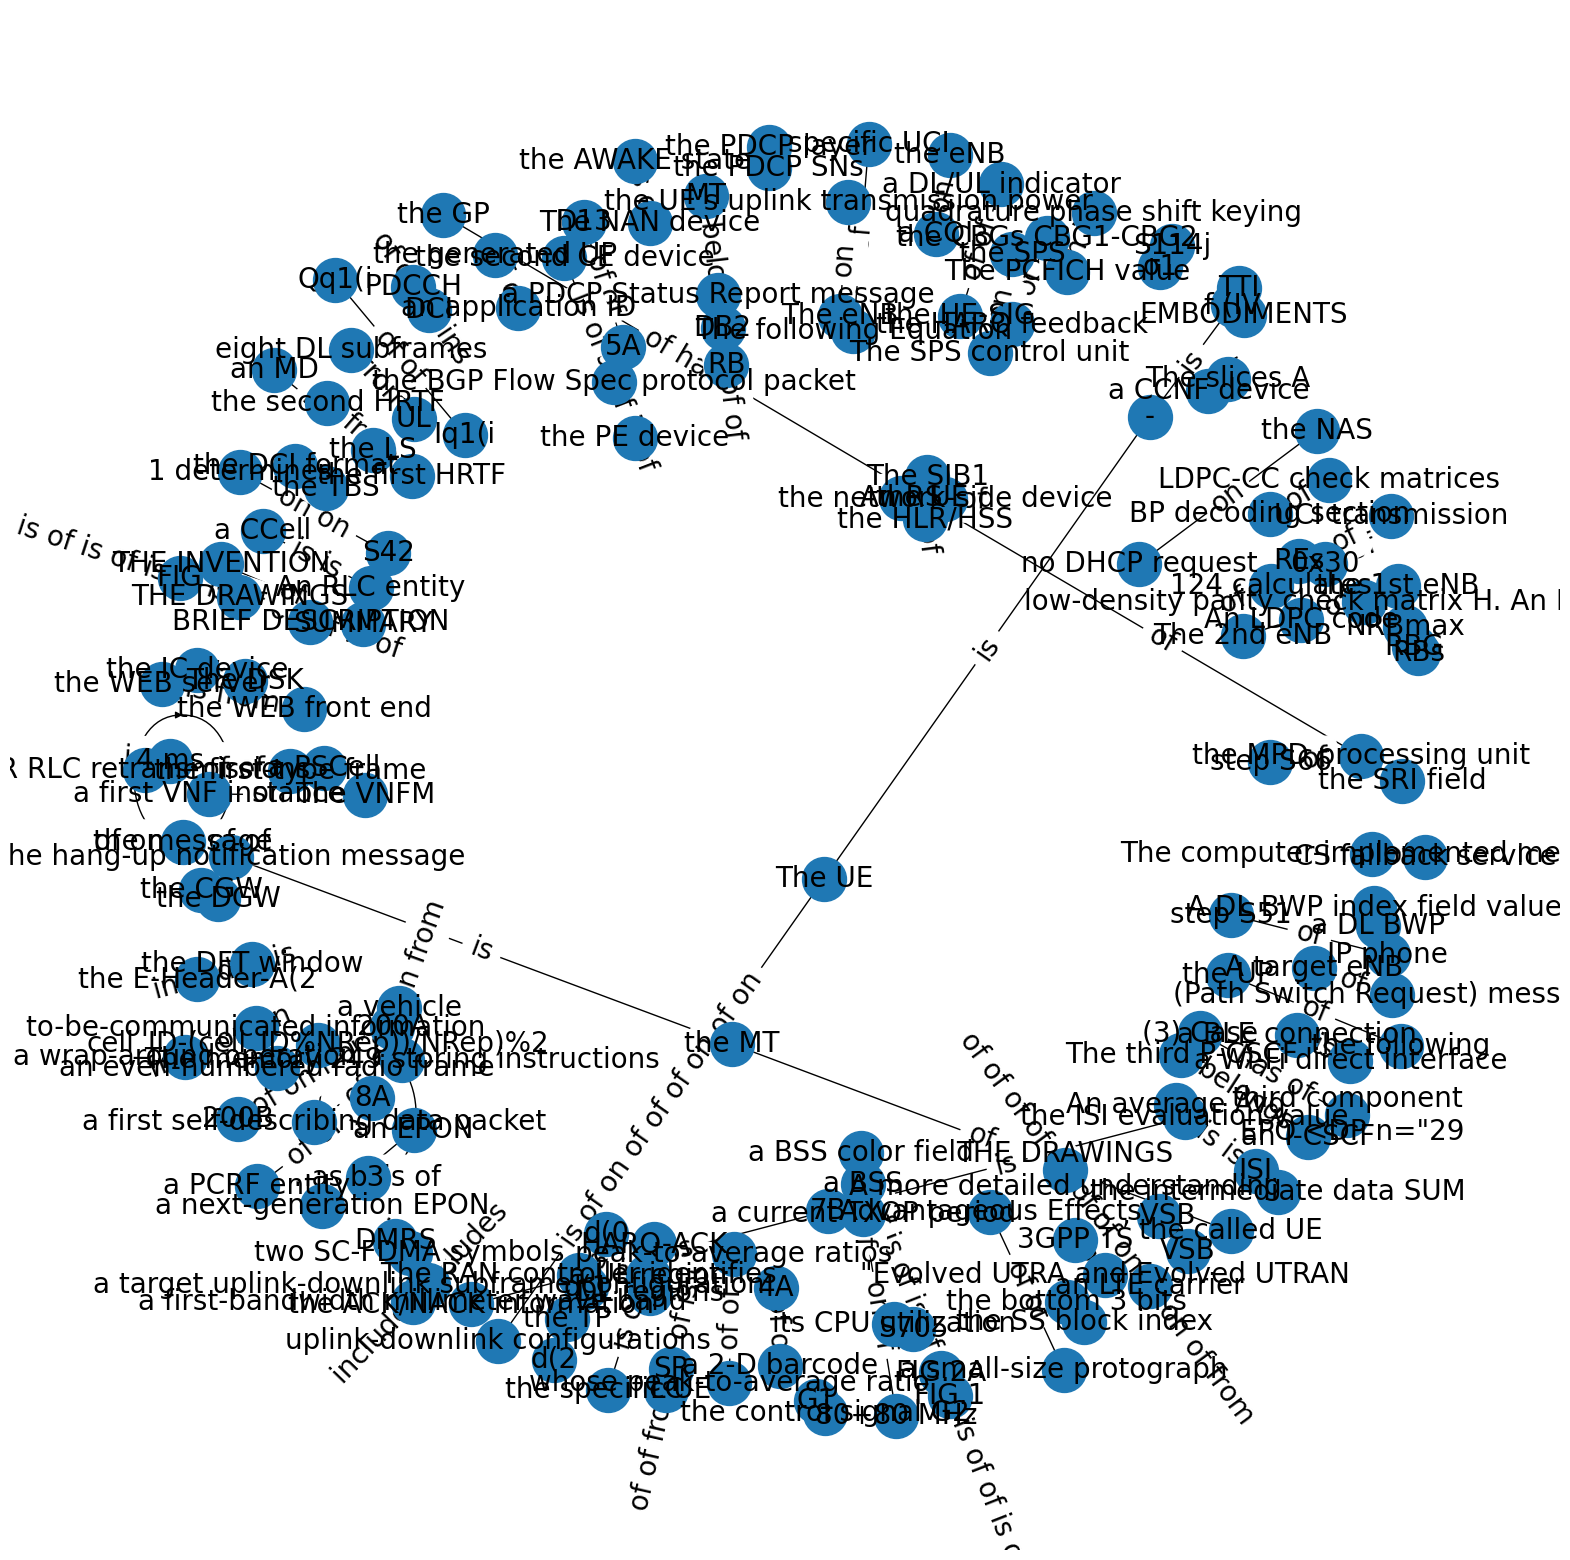

time: 2.48 s (started: 2023-05-05 16:59:33 +00:00)


In [25]:
# create an empty directed graph
G = nx.DiGraph()

# iterate over each relation and add it to the graph as an edge
for relation in relations:
    for r in relation:
        source = r["source"]
        target = r["target"]
        relation_text = r["relation"]
        G.add_edge(source, target, relation=relation_text)

# draw the graph
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=1000)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_edge_labels(G, pos, font_size=20, edge_labels=nx.get_edge_attributes(G, "relation"))
nx.draw_networkx_labels(G, pos, font_size=20)
plt.axis("off")
plt.show()

### 3.3 Improve relation extraction with spacy

In [26]:
# Define a list of spatial relation keywords
SPATIAL_RELATION_KEYWORDS = ["in", "on", "under", "below", "above", "beside", "near", "by", "at"]

def extract_relations(doc):
    """
    Extract relations between named entities in a Doc object.

    Args:
    - doc (spacy.tokens.Doc): a Doc object containing named entities

    Returns:
    - list: a list of dictionaries representing relations between named entities,
      with keys "source", "target", and "relation"
    """

    relations = []

    # iterate over each named entity in the Doc object
    for ent1 in doc.ents:
        for ent2 in doc.ents:

            # ignore relations between the same entity
            if ent1 == ent2:
                continue

            # check for terms between the two entities
            if has_terms_between((ent1.start, ent1.end), (ent2.start, ent2.end)):
                continue

            # check for spatial relations between the two entities
            for token in doc[min(ent1.start, ent2.start):max(ent1.end, ent2.end)]:
                if token.text.lower() in SPATIAL_RELATION_KEYWORDS:
                    relation_text = token.text.lower()

                    # add the relation to the list
                    relations.append({
                        "source": ent1.text,
                        "target": ent2.text,
                        "relation": relation_text
                    })
                    break

    return relations

# define the has_terms_between function
def has_terms_between(term1, term2):
    """
    Check if there are any terms between two terms.

    Args:
    - term1 (tuple): a tuple containing the start and end indices of a term
    - term2 (tuple): a tuple containing the start and end indices of a term

    Returns:
    - bool: True if there are terms between the two terms, False otherwise
    """
    for term in [term1, term2]:
        if not isinstance(term, tuple) or len(term) != 2 or not all(isinstance(i, int) for i in term):
            raise ValueError("Invalid term: {}".format(term))

    return any(token.i > term1[1] and token.i < term2[0] for token in doc)


time: 2.36 ms (started: 2023-05-05 16:59:36 +00:00)


In [27]:
# use improved approach to extract relations between terms
relations = []
# iterate over each row in the DataFrame
for row in filtered_gold_df.itertuples():
    sentence = row.sentences
    doc = nlp(sentence)

    # extract relations between named entities in the sentence
    relations = extract_relations(doc)

    # save the relations
    filtered_gold_df.at[row.Index, 'relations'] = relations
    
filtered_gold_df

sentences  \
1     Further, the network gives L (L≤M≤N) DL CCs to...   
4     An LDPC code is an error correction code defin...   
8     Different CSs of the same CAZAC sequence provi...   
10    Mobile telephones 3 with larger bandwidths can...   
14    For example, the LS 16 may be aware that in th...   
...                                                 ...   
1673  In this application, the PE device (that is, t...   
1675  The uplink data scheduling (MCS/precoder/rank)...   
1676  8, as metric_code, not only psnr, ssim, msim, ...   
1677  BRIEF DESCRIPTION OF THE DRAWINGS\nA more deta...   
1680  (Step S204) In the key management ECU 10, the ...   

                                                  terms  \
1     [(30, 35, TERM), (56, 71, TERM), (106, 108, TE...   
4     [(0, 12, TERM), (52, 99, TERM), (170, 211, TER...   
8       [(0, 13, TERM), (17, 40, TERM), (49, 75, TERM)]   
10    [(55, 72, TERM), (72, 73, TERM), (170, 185, TE...   
14    [(13, 19, TERM), (83, 88, TERM), (98, 104, TER...   
...                                                 ...   
1673  [(21, 34, TERM), (77, 110, TERM), (201, 221, T...   
1675  [(27, 45, TERM), (108, 125, TERM), (129, 135, ...   
1676   [(46, 50, TERM), (52, 56, TERM), (84, 91, TERM)]   
1677  [(0, 17, TERM), (21, 63, TERM), (235, 249, TER...   
1680  [(0, 10, TERM), (15, 37, TERM), (42, 49, TERM)...   

                                             terms_text  \
1                [L≤M≤N, a primary DL CC, UE, L DL CCs]   
4     [An LDPC code, low-density parity check matrix...   
8     [Different CSs, the same CAZAC sequence, ortho...   
10           [multiple 5MHz sub, -, the resource ID, -]   
14    [the LS, an MD, the MD, more than one IP addre...   
...                                                 ...   
1673  [the PE device, the BGP Flow Spec protocol pac...   
1675    [(MCS/precoder/rank, SRS transmissions, the UE]   
1676                              [j144, j247, ISO/IEC]   
1677  [BRIEF DESCRIPTION, THE DRAWINGS\nA more detai...   
1680  [(Step S204, the key management ECU, the CPU, ...   

                                              relations  
1     [{'source': 'UE', 'target': 'L≤M≤N', 'relation...  
4     [{'source': 'low-density parity check matrix H...  
8                                                    []  
10                                                   []  
14    [{'source': 'an MD', 'target': 'the LS', 'rela...  
...                                                 ...  
1673  [{'source': 'the second CE device', 'target': ...  
1675  [{'source': 'the non-precoded', 'target': 'MCS...  
1676                                                 []  
1677  [{'source': 'an LTE carrier', 'target': 'BRIEF...  
1680  [{'source': 'the key management ECU', 'target'...  

[349 rows x 4 columns]

time: 2.35 s (started: 2023-05-05 16:59:36 +00:00)


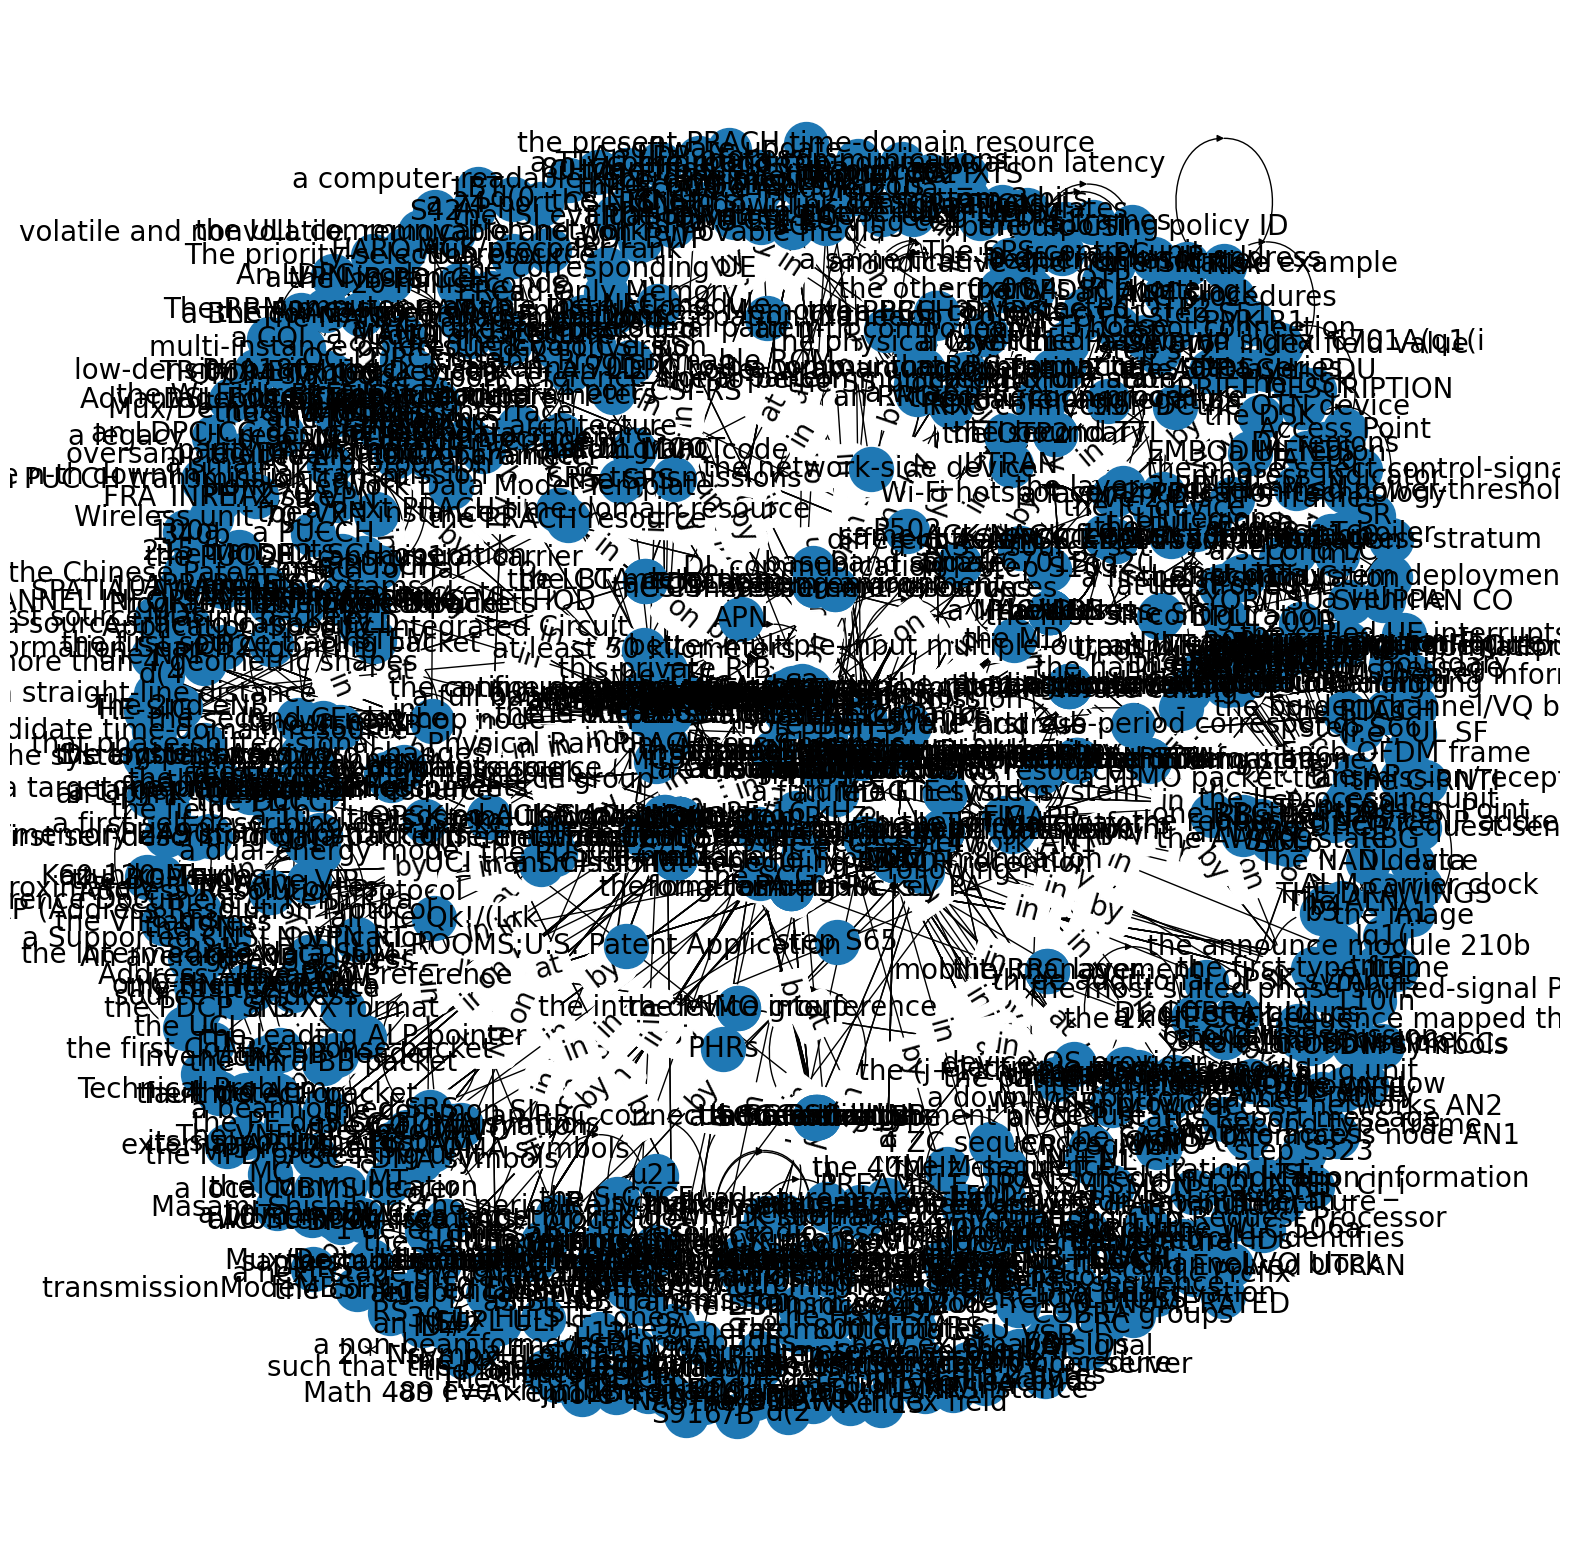

time: 27.3 s (started: 2023-05-05 16:59:38 +00:00)


In [28]:
# find the sentences containing a relation
relations = filtered_gold_df[filtered_gold_df['relations'].apply(lambda x: len(x) > 0)]["relations"]

# create an empty directed graph
G = nx.DiGraph()

# iterate over each relation and add it to the graph as an edge
for relation in relations:
    for r in relation:
        source = r["source"]
        target = r["target"]
        relation_text = r["relation"]
        G.add_edge(source, target, relation=relation_text)

# draw the graph
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=1000)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_edge_labels(G, pos, font_size=20, edge_labels=nx.get_edge_attributes(G, "relation"))
nx.draw_networkx_labels(G, pos, font_size=20)
plt.axis("off")
plt.show()

### 3.4 A bit modification

In [29]:
# create an empty directed graph
G = nx.DiGraph()

# iterate over each relation and add it to the graph as an edge
for relation in relations:
    for r in relation:
        source = r["source"]
        target = r["target"]
        relation_text = r["relation"]
        
        G.add_node(source)
        G.add_node(target)
        G.add_edge(source, target, relation=relation_text)

time: 12.5 ms (started: 2023-05-05 17:00:06 +00:00)


In [30]:
pos = nx.spring_layout(G, k=1, iterations=50)

time: 5.41 s (started: 2023-05-05 17:00:06 +00:00)


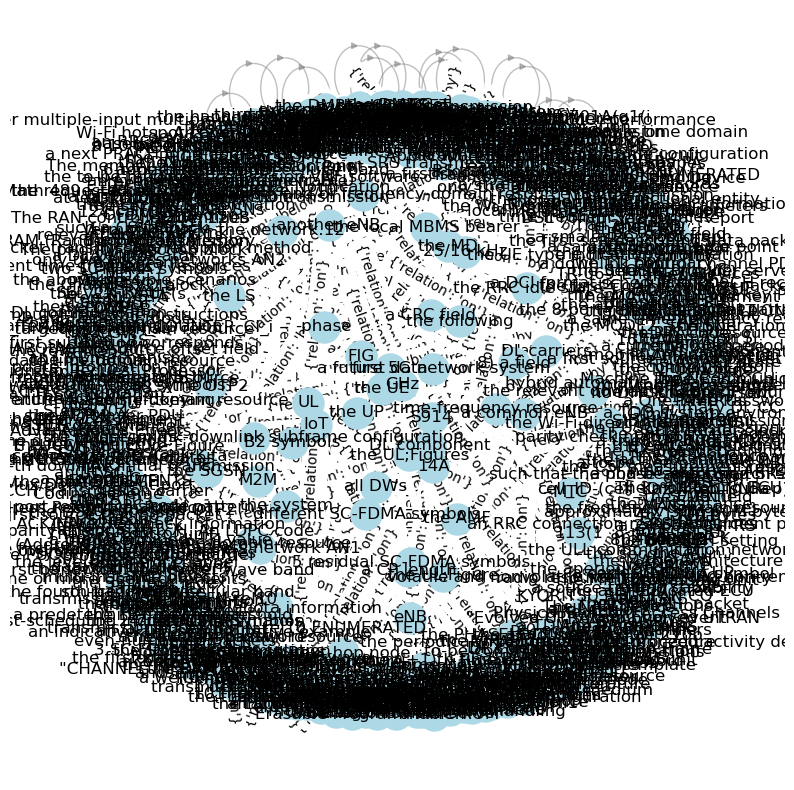

time: 26.1 s (started: 2023-05-05 17:00:12 +00:00)


In [31]:
# set up the graph
node_style = {'node_color': 'lightblue',
              'node_size': 500,}
edge_style = {'alpha': 0.5,
              'width': 1,
              'edge_color': 'gray',
              'arrows': True,
              'arrowstyle': '-|>'}

# draw the graph
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos, **node_style)
nx.draw_networkx_edges(G, pos, **edge_style)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edge_labels(G, pos, font_size=10)
plt.axis('off')
plt.show()